# Project for audio processing course
## COMP.SGN.120-2023-2024-1 Introduction to Audio Processing

### Name: Arttu Raatikainen
### Student number: H291629
### email: arttu.raatikainen@tuni.fi


Purpose of this project is to define a model based on audio files and train it to predict the category of audio files.
Audio file categories are Car and Bus. 
The model is trained with a dataset of 2 different categories of audio files. The model is then tested
with a test dataset of 2 different categories of audio files. 
Model uses binary classification



In [26]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pandas as pd
import librosa
import librosa.display
import os
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns


Read wav files from lists


In [27]:
carTrainFiles = []
carTestFiles = []
carValidFiles = []
# load car data

for filename in os.listdir('carTrain'):
    if filename.endswith(".wav"):
        carTrainFiles.append(f"carTrain/{filename}")

print("car train X: ", len(carTrainFiles))


for filename in os.listdir('carTest'):
    if filename.endswith(".wav"):
        carTestFiles.append(f"carTest/{filename}")

print("Car test X: ", len(carTestFiles))
print(carTestFiles[0])

for filename in os.listdir('carValidation'):
    if filename.endswith(".wav"):
        carValidFiles.append(f"carValidation/{filename}")

print("Car validation X: ", len(carValidFiles))

carTrainY = np.zeros(len(carTrainFiles))
carTestY = np.zeros(len(carTestFiles))
carValidY = np.zeros(len(carValidFiles))

print("car train Y: ", len(carTrainY), "car test Y: ", len(carTestY), "car valid Y: ", len(carValidY))

# load bus data
busTrainFiles = []
busTestFiles = []
busValidFiles = []

for filename in os.listdir('busTrain'):
    if filename.endswith(".wav"):
        busTrainFiles.append(f"busTrain/{filename}")

print("bus train X: ", len(busTrainFiles))

for filename in os.listdir('busTest'):
    if filename.endswith(".wav"):
        busTestFiles.append(f"busTest/{filename}")

print("bus test X: ", len(busTestFiles))

for filename in os.listdir('busValidation'):
    if filename.endswith(".wav"):
        busValidFiles.append(f"busValidation/{filename}")

print("bus validation X: ", len(busValidFiles))

busTrainY = np.ones(len(busTrainFiles))
busTestY = np.ones(len(busTestFiles))
busValidY = np.ones(len(busValidFiles))

print("bus train Y: ", len(busTrainY), "bus test Y: ", len(busTestY), "bus valid Y: ", len(busValidY))

car train X:  100
Car test X:  20
carTest/car6.wav
Car validation X:  20
car train Y:  100 car test Y:  20 car valid Y:  20
bus train X:  100
bus test X:  20
bus validation X:  20
bus train Y:  100 bus test Y:  20 bus valid Y:  20


In [28]:
def normalize_audio_files(filename):
    # return a list of normalized audio files
    # with [][] format where the first [] is the audio and the second [] is the sample rate

    audioData = []

  # read and normalize data: set length to 5 seconds and pad if necessary
    for file in filename:
        x, sr = librosa.load(file)

        targetSamples = 5 * sr

        if len(x) < targetSamples:
            x = np.pad(x, (0, targetSamples - len(x)), 'constant')
        elif len(x) > targetSamples:
            x = x[:targetSamples]

        audioData.append((x, sr))

    return audioData        

## Labels:
### 0, Car
### 1, Bus

Add files to one list and shuffle

In [29]:
XtrainFiles, Ytrain = shuffle(carTrainFiles + busTrainFiles, np.concatenate((carTrainY, busTrainY)).astype(int), random_state=0)
Xtrain = normalize_audio_files(XtrainFiles)

XtestFiles, Ytest = shuffle(carTestFiles + busTestFiles, np.concatenate((carTestY, busTestY)).astype(int), random_state=0)
Xtest = normalize_audio_files(XtestFiles)

XvalidFiles, Yvalid = shuffle(carValidFiles + busValidFiles, np.concatenate((carValidY, busValidY)).astype(int), random_state=0)
Xvalid = normalize_audio_files(XvalidFiles)


print("Xtrain: ", len(Xtrain), "Ytrain: ", len(Ytrain))
print("Xtest: ", len(Xtest), "Ytest: ", len(Ytest))
print("Xvalid: ", len(Xvalid), "Yvalid: ", len(Yvalid))


Xtrain:  200 Ytrain:  200
Xtest:  40 Ytest:  40
Xvalid:  40 Yvalid:  40


## Define plot functions for features
RMSE, MFCCs, Mel Spectrogram, Zero Crossing Rate, Spectal Centroids, Chromagram and Audio Signal

In [30]:
def plot_mel_spectrogram(x, fs, n_mels=128, name="Mel Spectrogram"):

    melSpec = librosa.feature.melspectrogram(y=x, sr=fs, n_mels=n_mels)
    melSpecDb = librosa.amplitude_to_db(abs(melSpec), ref=np.max)

    plt.figure( figsize=(10, 5) )
    librosa.display.specshow(melSpecDb, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB', label='Amplitude')
    plt.title(name)
    plt.xlabel("Time")
    plt.ylabel("Mels")
    plt.show()

def plot_mfcc(x, fs, n_mfcc, name="MFCC"):

    mfccs = librosa.feature.mfcc(y=x, sr=fs, n_mfcc=n_mfcc)

    plt.figure( figsize=(10, 5) )
    librosa.display.specshow(mfccs, x_axis='time', norm=Normalize(vmin=-20, vmax=20))
    plt.colorbar(format='%+2.0f dB')
    plt.title(name)
    plt.yticks()
    plt.xlabel("Time ")
    plt.ylabel("MFC Coefficients")
    plt.show()

def plot_zero_crossing_rate(x, fs, frame_length, hop_length, name="Zero Crossing Rate"):
    # calculate zero crossing rate for length of audio signal
    zcr = librosa.feature.zero_crossing_rate(y=x, frame_length=frame_length, hop_length=hop_length)[0]
    maxVal = np.max(np.abs(zcr))
    zcr = np.array(zcr) / maxVal if maxVal > 0 else zcr
    time_zcr = np.linspace(0, len(x)/fs, len(zcr))

    plt.figure( figsize=(10, 5) )
    plt.plot(time_zcr, zcr, color='r', label='Zero Crossing Rate')
    plt.title(name)
    plt.xlabel("Frames")
    plt.ylabel("Rate")
    plt.legend()
    plt.show()

def plot_spectral_centroid(x, fs, name="Spectral Centroid"):

    X = librosa.stft(x.astype(float))
    X_mag = np.abs(X)
    spectral_centroids = librosa.feature.spectral_centroid(S=X_mag, sr=fs)[0]
    spectral_centroids = np.array(spectral_centroids) / np.max(spectral_centroids) if np.max(spectral_centroids) > 0 else spectral_centroids
    t = librosa.frames_to_time(range(len(spectral_centroids)))

    plt.figure( figsize=(10, 5) )
    plt.plot(t, spectral_centroids, color='y')
    plt.title(name)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend(('Audio Signal', 'RMS', 'ZCR', 'Spectral Centroid'))
    plt.show()

def plot_rmse(x, fs, frame_length, hop_length, name="RMSE"):

    # calculate RMS Energy RMSE for length of audio signal
    rmse = []

    for i in range(0, len(x), hop_length):
        segment = x[i:i+frame_length]
        rmseVal = np.sqrt(np.mean(segment**2))
        rmse.append(rmseVal)
    
    #plot RMS in red with audio signal
    time_rmse = np.arange(len(rmse)) * hop_length / fs


    plt.figure( figsize=(10, 5) )
    plt.plot(time_rmse, rmse, color='g', label='RMSE')
    plt.title(name)
    plt.xlabel("Frames")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

def plot_signal(x, fs, name="Audio Signal"):

    plt.figure( figsize=(10, 5) )
    plt.plot(x)
    plt.title(name)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

def plot_chromagram(x, fs, name="Chromagram"):
    # calculate chromagram
    X = librosa.stft(x.astype(float))
    X_db = librosa.amplitude_to_db(np.abs(X), ref=np.max)
    chromagram = librosa.feature.chroma_stft(S=X_db, sr=fs)
    
    plt.figure( figsize=(10, 5) )
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
    plt.colorbar(label='Relative Intensity')
    plt.title(name)
    plt.xlabel("Time")
    plt.ylabel("Pitch Class")
    plt.show()


## Extract one file for Car and for bus from test data
### Inspect features for  audio signals

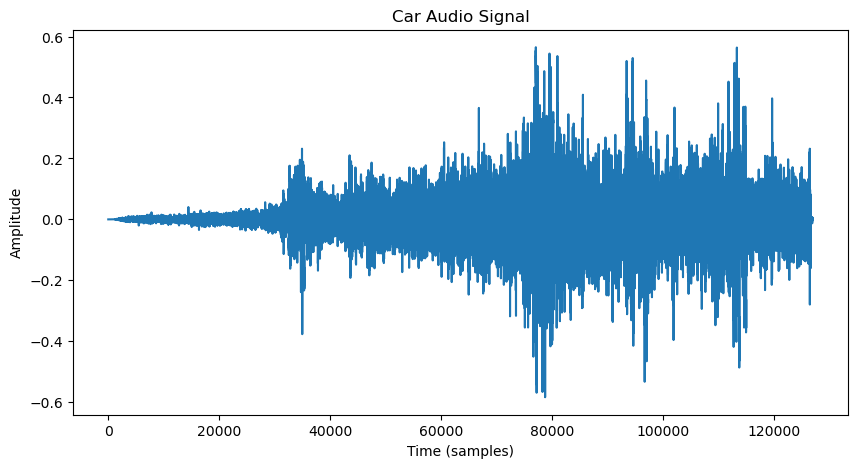

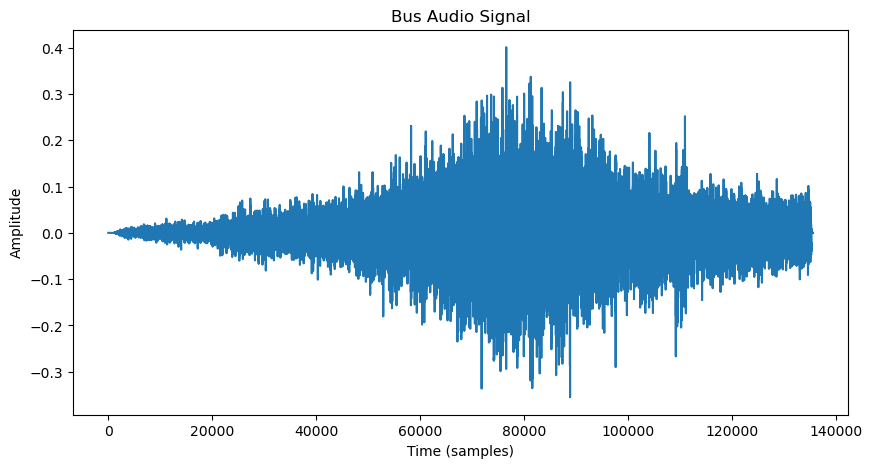

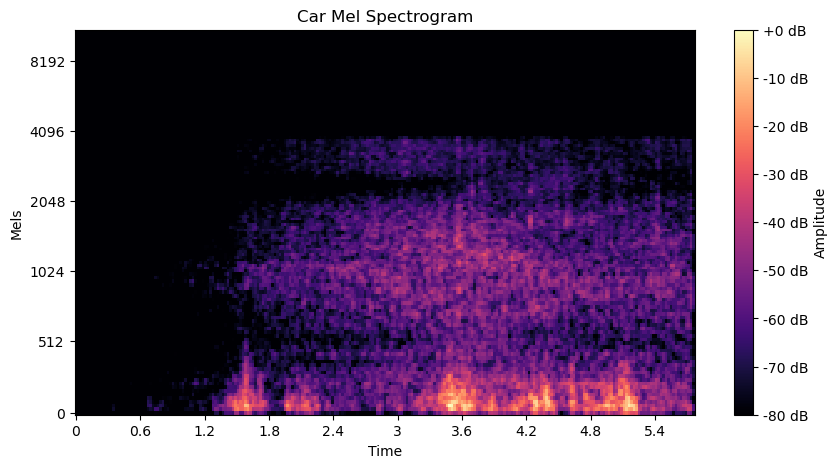

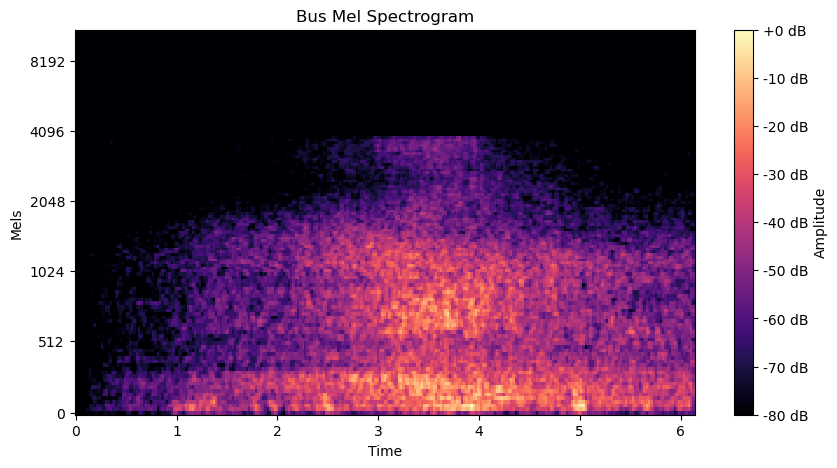

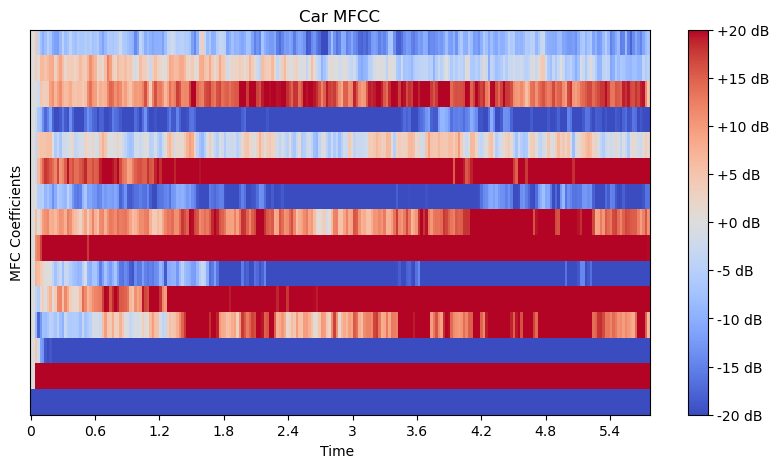

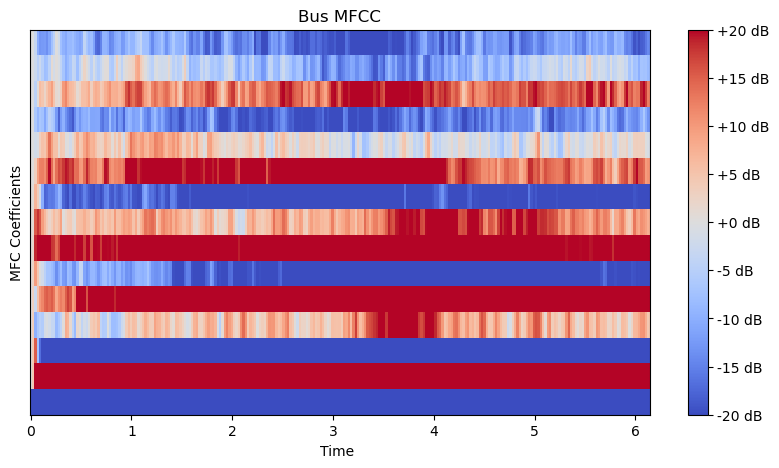

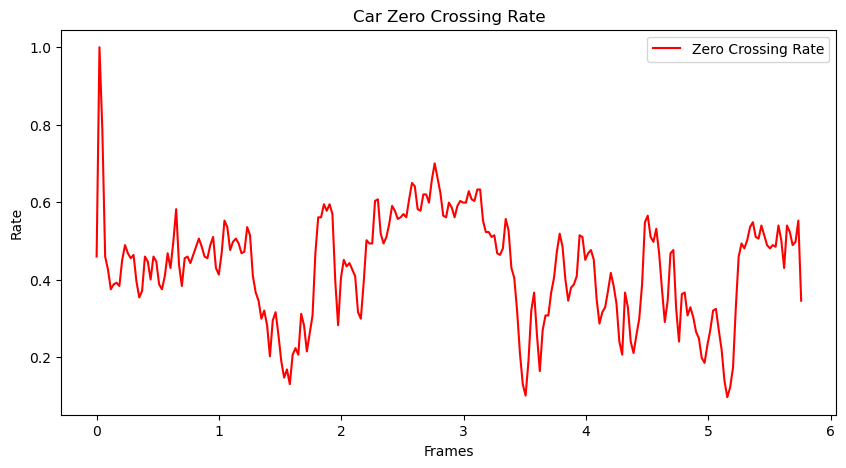

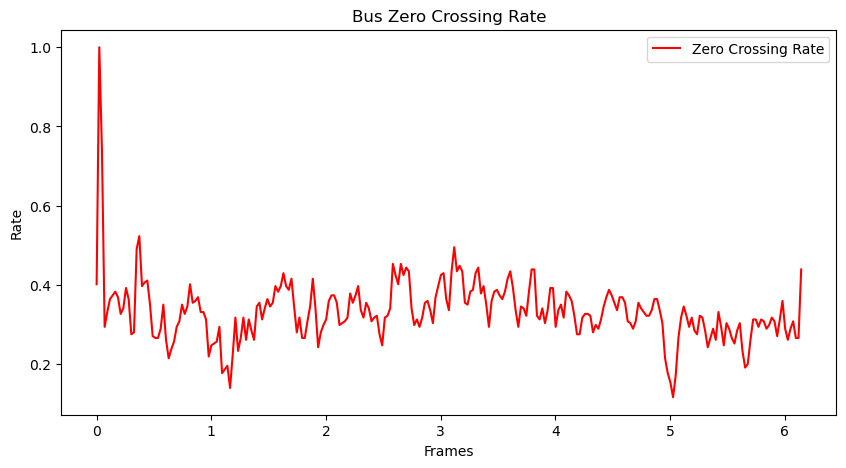

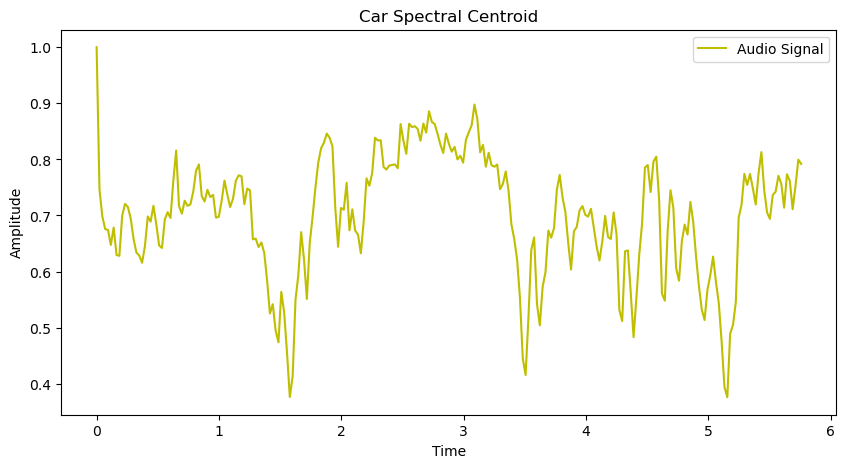

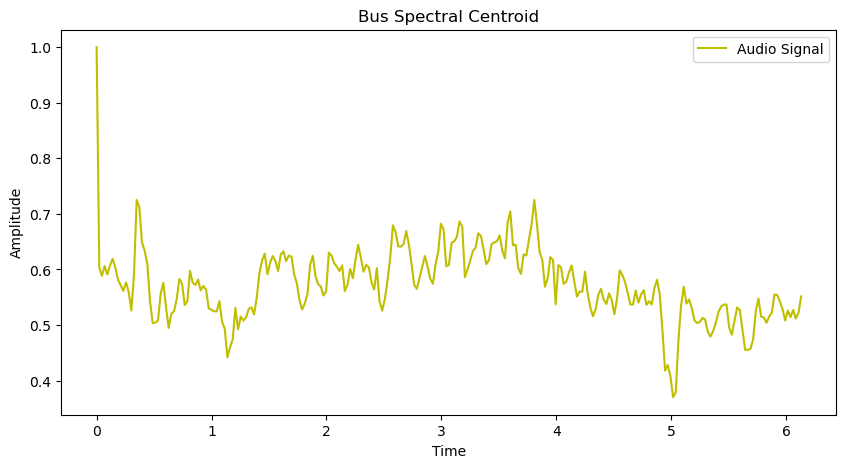

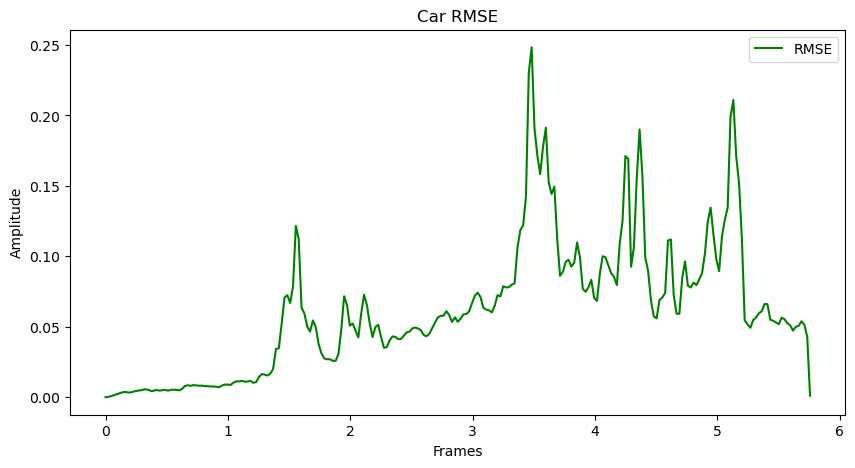

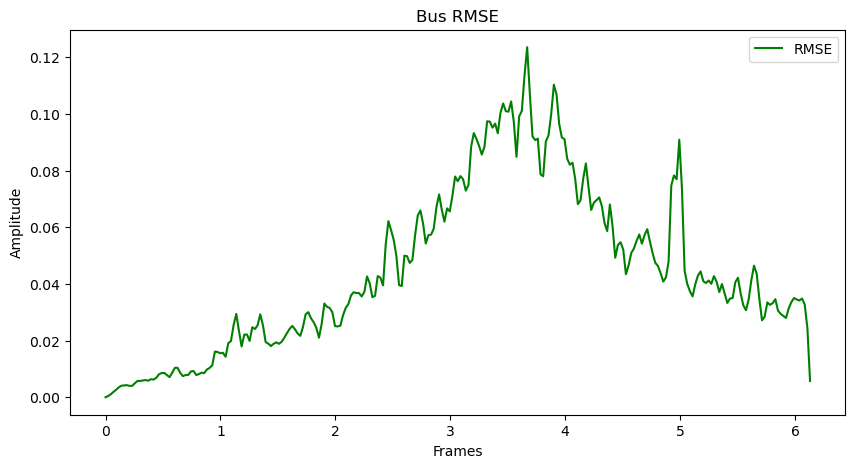

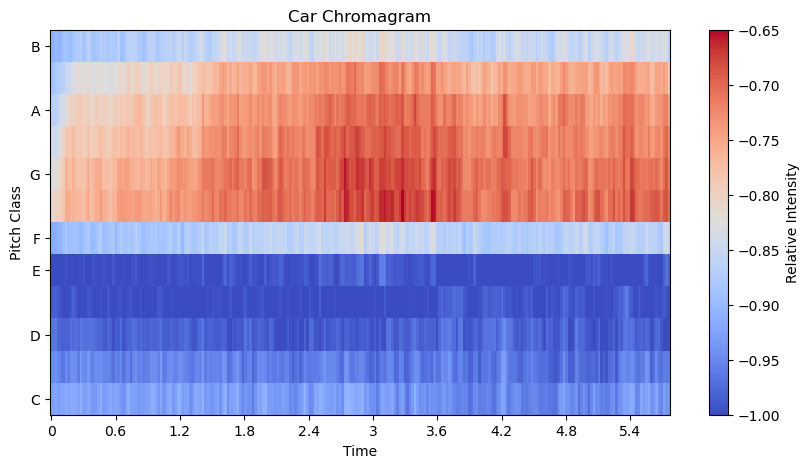

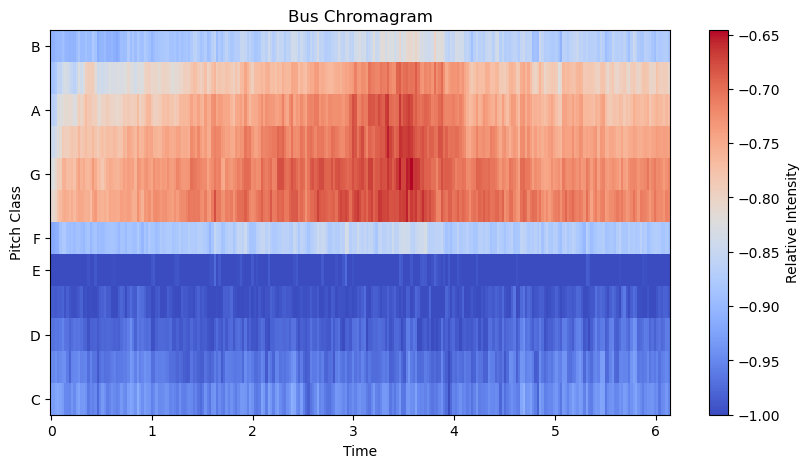

In [31]:
carFile = carTestFiles[0]
busFile = busTestFiles[0]

carX, carFs = librosa.load(carFile)
busX, busFs = librosa.load(busFile)

plot_signal(carX, carFs, "Car Audio Signal")
plot_signal(busX, busFs, "Bus Audio Signal")

plot_mel_spectrogram(carX, carFs, name="Car Mel Spectrogram")
plot_mel_spectrogram(busX, busFs, name="Bus Mel Spectrogram")

plot_mfcc(carX, carFs, 15, name="Car MFCC")
plot_mfcc(busX, busFs, 15, name="Bus MFCC")

plot_zero_crossing_rate(carX, carFs, 1024, 512, name="Car Zero Crossing Rate")
plot_zero_crossing_rate(busX, busFs, 1024, 512, name="Bus Zero Crossing Rate")

plot_spectral_centroid(carX, carFs, name="Car Spectral Centroid")
plot_spectral_centroid(busX, busFs, name="Bus Spectral Centroid")

plot_rmse(carX, carFs, 1024, 512, name="Car RMSE")
plot_rmse(busX, busFs, 1024, 512, name="Bus RMSE")

plot_chromagram(carX, carFs, name="Car Chromagram")
plot_chromagram(busX, busFs, name="Bus Chromagram")




## Extract features
RMSE, MFCCs, Mel Spectrogram, Zero Crossing Rate, Spectal Centroids and Chromagram

In [32]:

def extract_features(x, fs):

    # calculate RMS Energy RMSE for length of audio

    frame_length = 1024
    hop_length = 512
    rmse = []

    for i in range(0, len(x), hop_length):
        segment = x[i:i+frame_length]
        rmseVal = np.sqrt(np.mean(segment**2))
        rmse.append(rmseVal)
    

    # calculate MFCCs and tranform MFCCs to 1D array of mean values
    n_mfcc = 20
    mfc_coef = np.mean(librosa.feature.mfcc(y=x, sr=fs, n_mfcc=n_mfcc), axis=0)
    
    # calculate mel spectrogram and transform mel spectrogram to 1D array of mean values
    n_mels = 128
    mel = librosa.feature.melspectrogram(y=x, sr=fs, n_mels=n_mels)
    mel_mean = np.mean(mel, axis=0)


    # calculate zero crossing rate

    zcr = librosa.feature.zero_crossing_rate(y=x, frame_length=frame_length, hop_length=hop_length)[0]
    maxVal = np.max(np.abs(zcr))
    zcr = np.array(zcr) / maxVal if maxVal > 0 else zcr

    # calculate spectral centroid

    X = librosa.stft(x.astype(float))
    X_mag = np.abs(X)
    spectral_centroids = librosa.feature.spectral_centroid(S=X_mag, sr=fs)[0]
    spectral_centroids = np.array(spectral_centroids) / np.max(spectral_centroids) if np.max(spectral_centroids) > 0 else spectral_centroids

    # valmis
    # feature chromagram
    X_db = librosa.amplitude_to_db(np.abs(X), ref=np.max)
    chromagram = librosa.feature.chroma_stft(S=X_mag, sr=fs)
    chromagram_mean = np.mean(chromagram, axis=0)

    # if chromagram is empty, fill with zeros
    if len(chromagram_mean) == 0:
        chromagram_mean = np.zeros(216)

    #print("chromagram: ", len(chromagram_mean), "mfc_coef: ", len(mfc_coef), "mel_mean: ", len(mel_mean), "spectral_centroids: ", len(spectral_centroids), "zcr: ", len(zcr), "rmse: ", len(rmse))
    
    # create feature matrix
    feature_matrix = np.hstack((rmse, zcr, mfc_coef, mel_mean, chromagram_mean))

    return feature_matrix



In [33]:
# test feature extraction with known car and bus audio files
busX, busFs = Xtrain[1][0], Xtrain[1][1]
carX , carFs = Xtrain[3][0], Xtrain[3][1]


extract_features(carX, carFs)
extract_features(busX, busFs)

array([0.05201049, 0.05205852, 0.05795081, ..., 0.73424386, 0.82671185,
       0.83096003])

## Define model

Support vertor machine,
Nearest Neighbor,
Logistic regression,
Random Forest

In [34]:
# construct feature matrices for train, test, and validation sets

X_train_features = [extract_features(x, fs) for x, fs in Xtrain]
X_test_features = [extract_features(x, fs) for x, fs in Xtest]
X_valid_features = [extract_features(x, fs) for x, fs in Xvalid]
print("X_train_features: ", len(X_train_features), "X_test_features: ", len(X_test_features), "X_valid_features: ", len(X_valid_features))

/home/raati/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


X_train_features:  200 X_test_features:  40 X_valid_features:  40


# Train models

In [35]:
results = [ ['Model', 'Accuracy', 'Grid Accuracy'] ]

# train a model for SVC

svc_classifier = SVC()
svc_classifier.fit(X_train_features, Ytrain)

# predict on test set

Ytest_pred_svc = svc_classifier.predict(X_test_features)
accuracy = accuracy_score(Ytest, Ytest_pred_svc)

print("SVC results:")
print(classification_report(Ytest, Ytest_pred_svc))
print(f"Accuracy: {accuracy*100:.2f} %")

print("------------------------------------------------------")

# define the parameter grid for grid search

param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf'],
}


grid = GridSearchCV(svc_classifier, param_grid, scoring='accuracy', refit=True, cv=5, n_jobs=-1)
grid.fit(X_valid_features, Yvalid)

print("grid results:")
grid_best = grid.best_estimator_
grid_predictions = grid_best.predict(X_test_features)
grid_accuracy = accuracy_score(Ytest, grid_predictions)

print(classification_report(Ytest, grid_predictions))
print(f"Accuracy: {grid_accuracy*100:.2f} %")

results.append( ['SVC', round(accuracy*100,2), round(grid_accuracy*100,2)] )



SVC results:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        20
           1       0.78      0.70      0.74        20

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.75      0.75      0.75        40

Accuracy: 75.00 %
------------------------------------------------------
grid results:
              precision    recall  f1-score   support

           0       0.12      0.05      0.07        20
           1       0.41      0.65      0.50        20

    accuracy                           0.35        40
   macro avg       0.27      0.35      0.29        40
weighted avg       0.27      0.35      0.29        40

Accuracy: 35.00 %


In [36]:
# train model for KNN

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_features, Ytrain)

# predict on test set

Ytest_pred_knn = knn_classifier.predict(X_test_features)
accuracy = accuracy_score(Ytest, Ytest_pred_knn)

print("kNN results:")
print(classification_report(Ytest, Ytest_pred_knn))
print(f"Accuracy: {accuracy*100:.2f}")

print("------------------------------------------------------")

# define the parameter grid for grid search

param_grid = {
    'n_neighbors': [1,3, 5, 7, 9],
    'weights': ['distance'],
    'leaf_size': [10, 20, 30, 40, 50],
    'algorithm': ['auto', 'brute'],
    'n_jobs': [-1]
}

grid = GridSearchCV(knn_classifier, param_grid, refit=True, n_jobs=-1)
grid.fit(X_valid_features, Yvalid)

grid_best = grid.best_estimator_
grid_predictions = grid_best.predict(X_test_features)
grid_accuracy = accuracy_score(Ytest, grid_predictions)

print("grid results:")
print(classification_report(Ytest, grid_predictions))
print(f"Accuracy: {grid_accuracy*100:.2f} %")

results.append( ['kNN', round(accuracy*100,2), round(grid_accuracy*100,2)] )

kNN results:
              precision    recall  f1-score   support

           0       0.47      0.35      0.40        20
           1       0.48      0.60      0.53        20

    accuracy                           0.48        40
   macro avg       0.47      0.47      0.47        40
weighted avg       0.47      0.47      0.47        40

Accuracy: 47.50
------------------------------------------------------


grid results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.47      0.90      0.62        20

    accuracy                           0.45        40
   macro avg       0.24      0.45      0.31        40
weighted avg       0.24      0.45      0.31        40

Accuracy: 45.00 %


In [37]:
# train model for Logistic Regression

log_reg = LogisticRegression(max_iter=3000)
log_reg.fit(X_train_features, Ytrain)

# predict on test set
Ytest_pred_lr = log_reg.predict(X_test_features)
accuracy = accuracy_score(Ytest, Ytest_pred_lr)

print("Logistic Regression results:")
print(classification_report(Ytest, Ytest_pred_lr))
print(f"Accuracy: {accuracy*100:.2f}")

print("------------------------------------------------------")

# define the parameter grid for grid search

param_grid = {"C":np.logspace(-3,3,7), "penalty":["l2"]}

grid = GridSearchCV(log_reg, param_grid, scoring='accuracy', refit=True,cv=5, n_jobs=-1)
grid.fit(X_valid_features, Yvalid)

grid_best = grid.best_estimator_
grid_predictions = grid_best.predict(X_test_features)
grid_accuracy = accuracy_score(Ytest, grid_predictions)

print("grid results:")
print(classification_report(Ytest, grid_predictions))
print(f"Accuracy: {grid_accuracy*100:.2f} %")

results.append( ['Logistic Regression', round(accuracy*100,2), round(grid_accuracy*100,2)] )

Logistic Regression results:
              precision    recall  f1-score   support

           0       0.57      0.65      0.60        20
           1       0.59      0.50      0.54        20

    accuracy                           0.57        40
   macro avg       0.58      0.57      0.57        40
weighted avg       0.58      0.57      0.57        40

Accuracy: 57.50
------------------------------------------------------
grid results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.46      0.85      0.60        20

    accuracy                           0.42        40
   macro avg       0.23      0.42      0.30        40
weighted avg       0.23      0.42      0.30        40

Accuracy: 42.50 %


In [38]:
# Train a model for Random Forest

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_features, Ytrain)

# Predict on the test set
Ytest_pred_rf = rf_classifier.predict(X_test_features)
accuracy_rf = accuracy_score(Ytest, Ytest_pred_rf)

print("Random Forest results:")
print(classification_report(Ytest, Ytest_pred_rf))
print(f"Accuracy: {accuracy_rf*100:.2f} %")

print("------------------------------------------------------")

model = RandomForestClassifier(
    n_estimators = 500, 
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    random_state=42  
) 

model.fit(X_train_features, Ytrain)
print(model.score(X_train_features, Ytrain))
print(model.score(X_test_features, Ytest))

print("------------------------------------------------------")

param_grid_rf = {
    'warm_start': [True],
    'criterion': ['gini', 'entropy'],
    'oob_score': [True],
    'n_estimators': [300,400,500],
    'max_features': ['sqrt'],
    'random_state': [42]
}

# Create Grid Search
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring='accuracy', cv=5, n_jobs=-1)
grid_rf.fit(X_valid_features, Yvalid)

# Predict on the test set using the best estimator
best_estimator_rf = grid_rf.best_estimator_
Ytest_pred_rf_grid = best_estimator_rf.predict(X_test_features)

accuracy_rf_grid = accuracy_score(Ytest, Ytest_pred_rf_grid)

print("Random Forest with Grid Search results:")
print(classification_report(Ytest, Ytest_pred_rf_grid, zero_division=1))
print(f"Accuracy: {accuracy_rf_grid*100:.2f} %")

results.append( ['Random Forest', round(accuracy_rf*100,2), round(accuracy_rf_grid*100,2)] )

Random Forest results:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84        20
           1       0.88      0.75      0.81        20

    accuracy                           0.82        40
   macro avg       0.83      0.82      0.82        40
weighted avg       0.83      0.82      0.82        40

Accuracy: 82.50 %
------------------------------------------------------
1.0
0.875
------------------------------------------------------
Random Forest with Grid Search results:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        20
           1       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.75      0.50      0.33        40
weighted avg       0.75      0.50      0.33        40

Accuracy: 50.00 %


# Show results for Models

In [39]:
# create dataframe from results and show them descending by accuracy
df = pd.DataFrame(results[1:], columns=results[0])
df = df.sort_values(by=['Accuracy'], ascending=False)
print(df)


                 Model  Accuracy  Grid Accuracy
3        Random Forest      82.5           50.0
0                  SVC      75.0           35.0
2  Logistic Regression      57.5           42.5
1                  kNN      47.5           45.0


## Roc curves and confusion matrix for the two best models

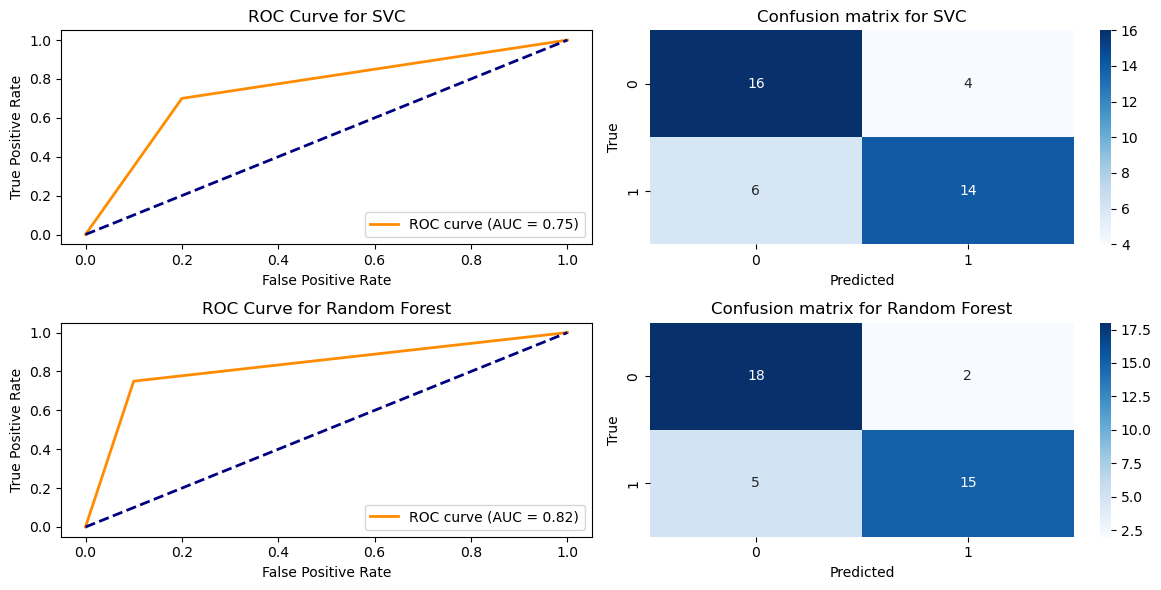

In [40]:

# Assuming the model's decision function for binary classification is stored in 'decision_scores'
fpr, tpr, _ = roc_curve(Ytest, Ytest_pred_svc)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVC')
plt.legend(loc="lower right")

# Confusion matrix

cm = confusion_matrix(Ytest, Ytest_pred_svc)

plt.subplot(2, 2, 2)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix for SVC')
plt.xlabel('Predicted')
plt.ylabel('True')


# same for random forest

fpr, tpr, _ = roc_curve(Ytest, Ytest_pred_rf)
roc_auc = auc(fpr, tpr)

plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right")

# Confusion matrix

cm = confusion_matrix(Ytest, Ytest_pred_rf)

plt.subplot(2, 2, 4)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


